# consolidate shelf files

In [1]:
import glob
import numpy as np
import dask
import xarray as xr
import distributed

import matplotlib.pyplot as plt
import cf_xarray

In [2]:
dirname = "/glade/p/nsc/ncgd0048/ETP_1_20/OCEAN_SHELF/"

In [ ]:
cluster = distributed.LocalCluster(threads_per_worker=1, n_workers=9, dashboard_address=":9797")

In [3]:
import ncar_jobqueue

cluster = ncar_jobqueue.NCARCluster(
    account="ncgd0048", scheduler_options=dict(dashboard_address=":9797")
)
cluster.scale(36)

In [4]:
client = distributed.Client(cluster)
client

Client Scheduler: tcp://10.12.205.28:43310 Dashboard: https://jupyterhub.ucar.edu/dav/user/dcherian/proxy/9797/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
allfiles = sorted(glob.glob(f"{dirname}/*.nc.*"))
patterns = np.unique([file[-16:-8] for file in allfiles])

In [6]:
def visualize_tile(da):
    import matplotlib.pyplot as plt

    x = da.cf["X"]
    y = da.cf["Y"]

    xl, xh = x.min().item(), x.max().item()
    yl, yh = y.min().item(), y.max().item()

    plt.plot(
        [xl, xl, xh, xh, xl],
        [yl, yh, yh, yl, yl],
        lw=2,
    )

    # print(
    #    [xl, xl, xh, xh, xl],
    #    [yl, yh, yh, yl, yl],
    #)



In [7]:
def preprocess_mom6_sections(ds):
    """
    Preprocess function for reading MOM6 field section output.

    Gets rid of dummy dimensions ("xh_sub01") and renames them to
    standard names ("xh")

    Intended use is the ``preprocess`` kwarg of xarray's ``open_mfdataset``.
    """

    import numpy as np

    # ds = ds[["vo"]]
    # "standard" dimension names
    standard_dims = ["xh", "xq", "yh", "yq"]

    for dim in standard_dims:
        matches = [dsdim for dsdim in ds.dims if dim in dsdim]
        if not matches:
            continue
        if len(matches) > 1:
            [
                np.testing.assert_equal(
                    ds.coords[matches[0]].values, ds.coords[other].values
                )
                for other in matches[1:]
            ]

        ds = ds.rename({matches[0]: dim})
        for match in matches[1:]:
            ds = ds.drop_vars(match).rename({match: dim})

    return ds.set_coords(["average_T1", "average_T2", "average_DT", "time_bnds"])

### manual combine

For some reason the domain is saved twice? 
* `*.01*` files `slice(35)` cover the whole domain 7x5 then 
* `*.0[2-3]*` files `slice(35, None)` cover it again with smaller tiles: 9x7

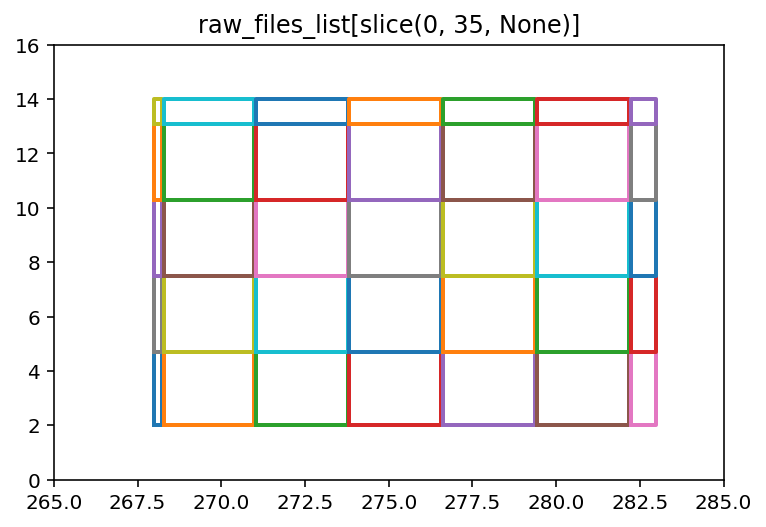

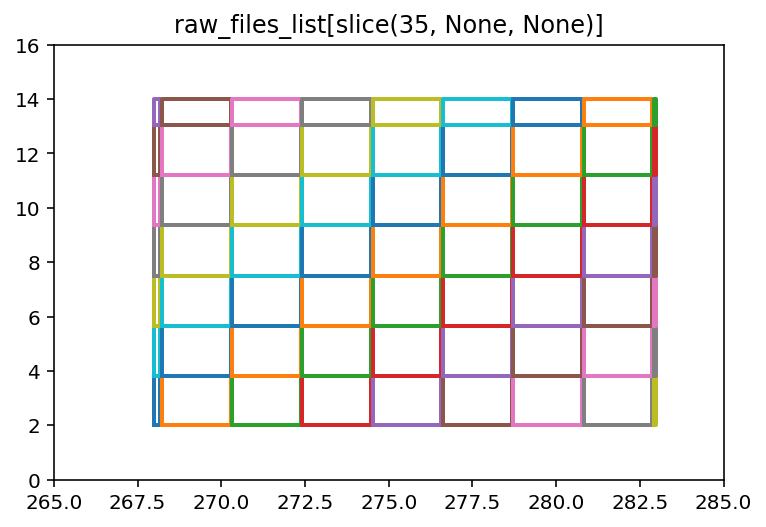

In [140]:
sorted(glob.glob(f"{dirname}/*{pattern}.nc*"))[35:]

['/glade/p/nsc/ncgd0048/ETP_1_20/OCEAN_SHELF/ocean_shelf__1993_001.nc.0231',
 '/glade/p/nsc/ncgd0048/ETP_1_20/OCEAN_SHELF/ocean_shelf__1993_001.nc.0232',
 '/glade/p/nsc/ncgd0048/ETP_1_20/OCEAN_SHELF/ocean_shelf__1993_001.nc.0233',
 '/glade/p/nsc/ncgd0048/ETP_1_20/OCEAN_SHELF/ocean_shelf__1993_001.nc.0234',
 '/glade/p/nsc/ncgd0048/ETP_1_20/OCEAN_SHELF/ocean_shelf__1993_001.nc.0235',
 '/glade/p/nsc/ncgd0048/ETP_1_20/OCEAN_SHELF/ocean_shelf__1993_001.nc.0236',
 '/glade/p/nsc/ncgd0048/ETP_1_20/OCEAN_SHELF/ocean_shelf__1993_001.nc.0237',
 '/glade/p/nsc/ncgd0048/ETP_1_20/OCEAN_SHELF/ocean_shelf__1993_001.nc.0238',
 '/glade/p/nsc/ncgd0048/ETP_1_20/OCEAN_SHELF/ocean_shelf__1993_001.nc.0239',
 '/glade/p/nsc/ncgd0048/ETP_1_20/OCEAN_SHELF/ocean_shelf__1993_001.nc.0255',
 '/glade/p/nsc/ncgd0048/ETP_1_20/OCEAN_SHELF/ocean_shelf__1993_001.nc.0256',
 '/glade/p/nsc/ncgd0048/ETP_1_20/OCEAN_SHELF/ocean_shelf__1993_001.nc.0257',
 '/glade/p/nsc/ncgd0048/ETP_1_20/OCEAN_SHELF/ocean_shelf__1993_001.nc.0258',

In [8]:
def read_raw_files(pattern, debug=False, parallel=False):

    if parallel:
        open_ = dask.delayed(xr.open_dataset)
        chunks = {"zl": 40, "zi": 40}
    else:
        open_ = xr.open_dataset
        chunks = None

    raw_dsets = [
        open_(ff, use_cftime=True, chunks=chunks)
        for ff in sorted(glob.glob(f"{dirname}/*{pattern}.nc*"))
    ]

    if parallel:
        raw_dsets = dask.compute(*raw_dsets)

    raw_files_list = [preprocess_mom6_sections(ds) for ds in raw_dsets]

    if debug:
        for ranges in [slice(0, 35), slice(35, None)]:
            plt.figure()
            [visualize_tile(ds.vo) for ds in raw_files_list[ranges]]
            plt.title(f"raw_files_list[{ranges}]")
            plt.xlim([265, 285])
            plt.ylim([0, 16])

    return raw_files_list


def trim_row(raw_files, axis, debug=False):
    trimmed = np.empty_like(raw_files)
    for irow, row in enumerate(raw_files):
        N = len(row)
        for i0, i1 in zip(range(N - 1), range(1, N)):
            ds0 = row[i0]  # [[varname]]
            ds1 = row[i1]  # [[varname]]
            drop_labels = {}
            for dim in ds0.cf.axes[axis]:
                bad = ds0.indexes[dim].intersection(ds1.indexes[dim])
                if not bad.empty:
                    drop_labels[dim] = bad

            if debug:
                print(drop_labels)
            trimmed[irow, i0] = ds0.drop_sel(drop_labels)

            # sanity check
            for dim in ds0.cf.axes[axis]:
                bad = ds1.indexes[dim].intersection(trimmed[irow, i0].indexes[dim])
                assert bad.empty

        trimmed[irow, -1] = raw_files[irow, -1]

    return trimmed


def combine_manual(raw_files, debug=False):
    import cf_xarray

    trimmed = trim_row(raw_files, axis="X", debug=debug)
    # trimmed = trim_row(trimmed, axis="X")
    trimmed = trim_row(trimmed.T, axis="Y", debug=debug).T

    if debug:
        [visualize_tile(ds.uo) for ds in trimmed.flat]

    kwargs = dict(coords="minimal", compat="override")

    first = trimmed[0, 0]
    combined = xr.Dataset()
    for var in first:
        X = first[var].cf.axes["X"]
        Y = first[var].cf.axes["Y"]

        assert len(X) == 1
        assert len(Y) == 1

        X = X[0]
        Y = Y[0]

        for row in trimmed:
            assert all([ds.indexes[X].is_monotonic for ds in row])
            assert all([ds.indexes[X].is_unique for ds in row])

        combined[var] = xr.concat(
            [xr.concat([ds[var] for ds in row], dim=X, **kwargs) for row in trimmed],
            dim=Y,
            **kwargs,
        )

    return combined


def tile_raw_files(subset, x, y):
    raw_files = np.empty(len(subset), dtype="O")
    raw_files[:] = subset
    raw_files = raw_files.reshape(y, x)
    return raw_files


def all_steps(pattern):

    # compressor = zarr.Blosc(cname="zstd", clevel=3, shuffle=2)
    # encoding = {var: {"compressor": compressor} for var in concat}
    # final_chunks = {"yh": 55, "yq": 55, "xh": 55, "xq": 55}

    # complevel=4 makes no difference
    compr_dict = dict(zlib=True, complevel=1, _FillValue=None)

    with dask.config.set(scheduler="single-threaded"):
        raw_files_list = read_raw_files(pattern, parallel=False)
        if not raw_files_list:
            raise ValueError(f"bad pattern: {pattern}")
        if len(raw_files_list) not in [35, 98]:
            raise ValueError(f"wrong number of files for pattern: {pattern}")

        combined1 = combine_manual(tile_raw_files(raw_files_list[:35], 7, 5))
        name = f"{dirname}/daily/ocean_shelf_{pattern}.nc"
        combined1.to_netcdf(
            name,
            unlimited_dims=["time"],
            encoding=dict.fromkeys(combined1.variables, compr_dict),
        )
    # combined1.chunk(final_chunks).to_zarr(name, mode="w", encoding=encoding)
    # return combined1, name

    # if len(raw_files_list) == 98:
    #    combined2 = combine_manual(tile_raw_files(raw_files_list[35:], 9, 7))
    #    combined2.compute().to_netcdf(f"{dirname}/daily/merged_23_ocean_shelf_{pattern}.nc")

The two combined datasets are slightly different

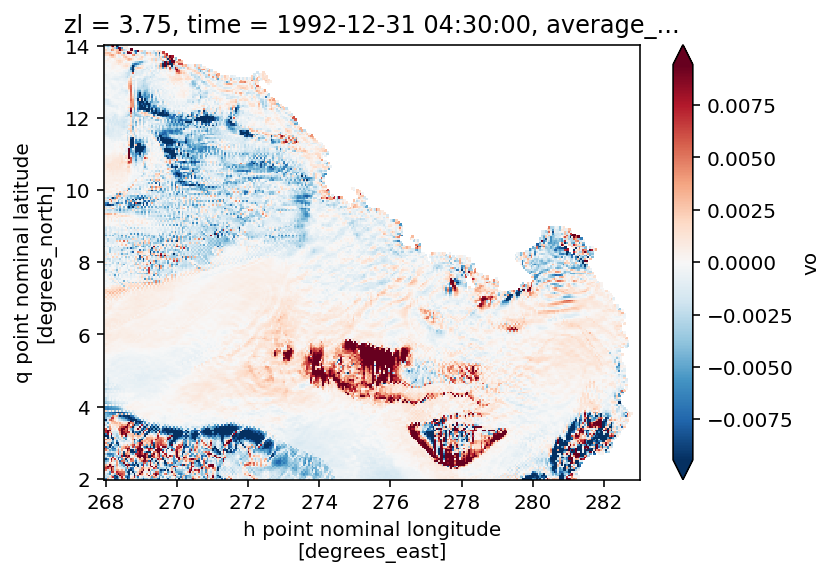

In [280]:
var = 'vo'
with xr.set_options(arithmetic_join="exact"):
    (combined2[var]- combined1[var]).isel(time=1, zl=1).plot(robust=True)

In [27]:
client.restart()

Client Scheduler: tcp://10.12.205.30:38100 Dashboard: https://jupyterhub.ucar.edu/dav/user/dcherian/proxy/9797/status,Cluster Workers: 35 Cores: 35 Memory: 875.00 GB


In [25]:
more = [
 "2008_061",
 "2007_069",
 "2007_073",
 "2008_304",
 "2002_109",
 "2002_112",
 "2002_111",
 "2002_110",
 "2008_303",
 "2000_203",
 "2001_193",
 "1996_215",
]

In [9]:
patterns

array(['2009_001', '2009_002', '2009_003', ..., '2014_363', '2014_364',
       '2014_365'], dtype='<U8')

In [12]:
tasks = [dask.delayed(all_steps)(pattern) for pattern in patterns]
dask.compute(*tasks, scheduler=client);

In [5]:
out_files = [ff.split("/")[-1][12:-3] for ff in sorted(glob.glob(f"{dirname}/daily/*.nc"))]
remaining = sorted(set(patterns) - set(out_files))
print(remaining)

[]


In [ ]:
cluster.close()

## Test output

In [12]:
client.restart()

Client Scheduler: tcp://10.12.205.30:40639 Dashboard: https://jupyterhub.ucar.edu/dav/user/dcherian/proxy/9797/status,Cluster Workers: 35 Cores: 35 Memory: 875.00 GB


In [13]:
ds = xr.open_mfdataset(f"{dirname}/daily/*.nc", parallel=True,)

In [44]:
combined = combine_manual(tile_raw_files(raw_files, 7,5))

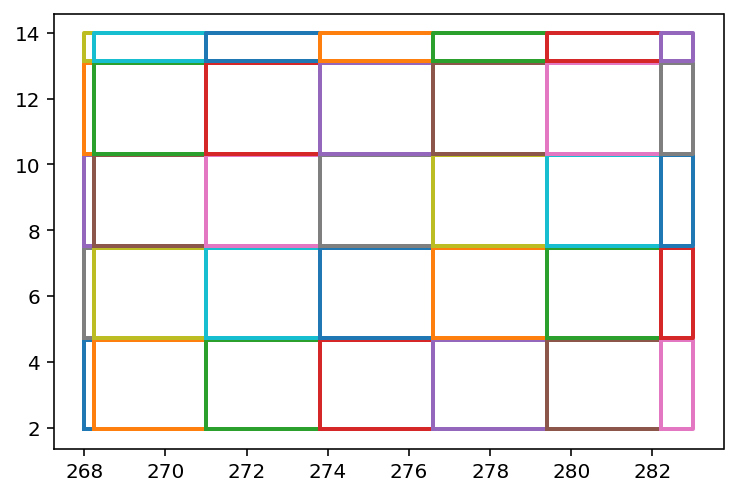

In [53]:
raw_files = read_raw_files("2001_003");
[visualize_tile(ds.uo) for ds in raw_files]
combined = combine_manual(tile_raw_files(raw_files, 7,5))

In [54]:
combined.time

<xarray.DataArray 'time' (time: 8)>
array([cftime.DatetimeGregorian(2001, 1, 1, 1, 30, 0, 0),
       cftime.DatetimeGregorian(2001, 1, 1, 4, 30, 0, 0),
       cftime.DatetimeGregorian(2001, 1, 1, 7, 30, 0, 0),
       cftime.DatetimeGregorian(2001, 1, 1, 10, 30, 0, 0),
       cftime.DatetimeGregorian(2001, 1, 1, 13, 30, 0, 0),
       cftime.DatetimeGregorian(2001, 1, 1, 16, 30, 0, 0),
       cftime.DatetimeGregorian(2001, 1, 1, 19, 30, 0, 0),
       cftime.DatetimeGregorian(2001, 1, 1, 22, 30, 0, 0)], dtype=object)
Coordinates:
  * time        (time) object 2001-01-01 01:30:00 ... 2001-01-01 22:30:00
    average_T1  (time) object ...
    average_T2  (time) object ...
    average_DT  (time) timedelta64[ns] ...
Attributes:
    long_name:       time
    cartesian_axis:  T
    calendar_type:   GREGORIAN
    bounds:          time_bnds

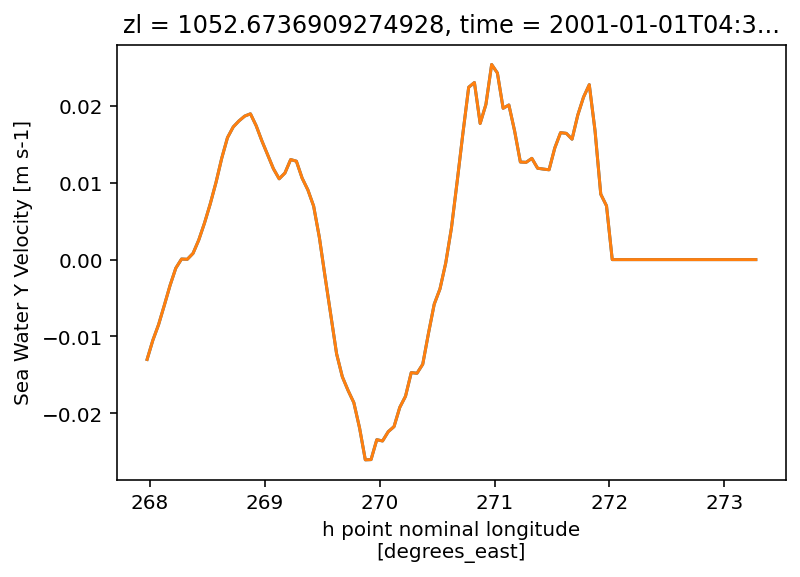

In [58]:
%matplotlib inline

plt.figure();
for d in [combined, ds.sel(time="2001-01-01")]:
    d.vo.isel(time=1, zl=100).cf.sel(Y=12, method="nearest").plot()


In [26]:
%matplotlib widget

ds.sel(time="2001-01-01").vo.isel(time=1, zl=100).cf.sel(Y=12, method="nearest").plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [90]:
for year in np.unique(ds.time.dt.year)[3:]:
    print(year)
    per = ds.sel(time=str(year)).mean().compute()
    # client.ca ncel(per)

1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008


In [32]:
mean = ds.resample(time="M").mean().persist()

## Zarr attempt

In [92]:
%%time 

datasets_and_names = dask.compute(*tasks)
new_datasets, filenames = zip(*datasets_and_names)  # unzip

In [93]:
import zarr

concat = xr.concat(
    new_datasets,
    dim="time",
    data_vars="minimal",
    coords="minimal",
    compat="override",
).chunk(final_chunks)

In [ ]:
concat.isel(time=slice(100)).to_zarr(
    f"{dirname}/daily/ocean_shelf.zarr", mode="w", consolidated=True, encoding=encoding
)

In [99]:
write_tasks = xr.save_mfdataset(new_datasets, filenames, format="netcdf4", mode="w")

tornado.application - ERROR - Uncaught exception GET /individual-task-stream/ws (::1)
HTTPServerRequest(protocol='http', host='localhost:8888', method='GET', uri='/individual-task-stream/ws', version='HTTP/1.1', remote_ip='::1')
Traceback (most recent call last):
  File "/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/tornado/websocket.py", line 956, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/tornado/web.py", line 3178, in wrapper
    return method(self, *args, **kwargs)
  File "/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/bokeh/server/views/ws.py", line 137, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: Token is expired.


KeyboardInterrupt: 

## rechunker

In [191]:
target_chunks = {}
for var in final.variables:
    if dask.base.is_dask_collection(final.variables[var]):
        target_chunks[var] = tuple(c[0] for c in final.variables[var].data.chunks)
target_chunks

{'uo': (8, 140, 30, 301),
 'vo': (8, 140, 30, 301),
 'zos': (8, 30, 301),
 'thetao': (8, 140, 30, 301),
 'so': (8, 140, 30, 301),
 'taux': (8, 30, 301),
 'tauy': (8, 30, 301),
 'net_heat_surface': (8, 30, 301),
 'SW': (8, 30, 301),
 'Tflx_dia_diff': (8, 141, 30, 301),
 'Sflx_dia_diff': (8, 141, 30, 301),
 'Kd_heat': (8, 141, 30, 301),
 'Kd_salt': (8, 141, 30, 301),
 'Kd_ePBL': (8, 141, 30, 301),
 'Kd_shear': (8, 141, 30, 301),
 'Kv_u': (8, 140, 30, 301),
 'ePBL_h_ML': (8, 30, 301),
 'bbl_thick_u': (8, 30, 301),
 'kv_bbl_u': (8, 30, 301),
 'Kd_BBL': (8, 141, 30, 301),
 'average_T1': (32,),
 'average_T2': (32,),
 'average_DT': (32,),
 'time_bnds': (32, 2)}

From https://gist.github.com/eric-czech/c5628e1f895e7c93b6096ce95862ac78

In [ ]:
! rm -rf /glade/p/nsc/ncgd0048/ETP_1_20/OCEAN_SHELF/daily/temp.zarr
! rm -rf /glade/p/nsc/ncgd0048/ETP_1_20/OCEAN_SHELF/daily/merged.zarr

rechunker.api.rechunk(
    concat.chunk({"yh": 10, "yq": 10}),
    target_chunks=target_chunks,
    max_mem="4GB",
    target_store=f"{dirname}/daily/merged.zarr",
    temp_store=f"{dirname}/daily/temp.zarr",
).execute()

## open_mfdataset attempt

In [ ]:
def combine_by_day(pat, outdir):
    dsets = []
    with dask.config.set(**{"array.slicing.split_large_chunks": True}):
        # combine along latitude band
        for i in range(1, 4):
            dsets.append(
                xr.open_mfdataset(
                    sorted(glob.glob(f"{dirname}/*{pat}*.nc.0{i}*")),
                    preprocess=preprocess_mom6_sections,
                    parallel=True,
                    use_cftime=True,
                    join="outer",
                    coords="minimal",
                    data_vars="minimal",
                    compat="override",
                    combine="by_coords",
                    chunks=-1,
                    # engine="h5netcdf",
                )
            )
        # concatenate along latitude
        combined = xr.combine_by_coords(
            dsets,
            coords="minimal",
            data_vars="minimal",
            combine_attrs="override",
            compat="override",
        ).load()

    combined.to_netcdf(f"{outdir}/ocean_shelf__{pat}.nc")
    return dsets, combined


# tasks = [dask.delayed(combine_by_day)(pat, f"./") for pat in patterns[:4]]

dsets, combined = combine_by_day("1993_001", "./")

## combine_first attempt

TOo inneficient

In [220]:
def new_combine(pattern):
    (raw_files,) = dask.compute(
        [
            dask.delayed(xr.open_dataset)(ff, use_cftime=True, chunks={"zl": 40, "zi": 40})
            for ff in sorted(glob.glob(f"{dirname}/*{pattern}.nc*"))
        ]
    )
    raw_files = [preprocess_mom6_sections(ds) for ds in raw_files]
    with dask.config.set(**{"array.slicing.split_large_chunks": True}):
        result = raw_files[0]
        for ds in raw_files:
            result = result.combine_first(ds)

    return dask.optimize(result)[0], f"ocean_shelf_{pattern}.nc"

tasks = [dask.delayed(new_combine)(pattern) for pattern in patterns[:4]]

### zarr : fails

In [177]:
concat.chunk({"yh": 30, "yq": 30}).to_zarr(
    f"{dirname}/daily/merged.zarr", mode="w", consolidated=True
)

KeyboardInterrupt: 

### netcdf : fails

In [151]:
xr.save_mfdataset(
    new_datasets, [f"{dirname}/daily/{fname}" for fname in filenames], format="netcdf4"
)

KeyboardInterrupt: 

In [132]:
plt.close();
result.thetao.isel(time=0, zl=0).plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [108]:
raw_files[0].vo.cf.isel(X=-1)
# raw_files[1].vo.cf.isel(X=0)

<xarray.DataArray 'vo' (time: 8, zl: 140, yq_sub01: 55)>
dask.array<getitem, shape=(8, 140, 55), dtype=float32, chunksize=(8, 140, 55), chunktype=numpy.ndarray>
Coordinates:
  * zl        (zl) float64 1.25 3.75 6.25 8.75 ... 6.074e+03 6.324e+03 6.475e+03
  * time      (time) object 1992-12-30 01:30:00 ... 1992-12-30 22:30:00
    xh_sub01  float64 268.2
  * yq_sub01  (yq_sub01) float64 2.0 2.05 2.1 2.15 2.2 ... 4.5 4.55 4.6 4.65 4.7
Attributes:
    long_name:      Sea Water Y Velocity
    units:          m s-1
    cell_methods:   zl:mean yq:point xh:mean time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_y_velocity
    interp_method:  none

In [15]:
dask.compute(tasks)

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


([<xarray.Dataset>
  Dimensions:           (nv: 2, time: 8, xh: 301, xq: 309, yh: 241, yq: 247, zi: 141, zl: 140)
  Coordinates:
    * yh                (yh) float64 1.975 2.025 2.075 2.125 ... 13.88 13.93 13.98
    * xh                (xh) float64 268.0 268.0 268.1 268.1 ... 282.9 282.9 283.0
    * xq                (xq) float64 268.0 268.1 268.1 268.1 ... 282.9 282.9 283.0
    * zl                (zl) float64 1.25 3.75 6.25 ... 6.324e+03 6.475e+03
    * time              (time) object 1992-12-30 01:30:00 ... 1992-12-30 22:30:00
    * nv                (nv) float64 1.0 2.0
    * yq                (yq) float64 2.0 2.05 2.1 2.15 ... 13.85 13.9 13.95 14.0
    * zi                (zi) float64 0.0 2.5 5.0 ... 6.199e+03 6.449e+03 6.5e+03
      average_T1        (time) object dask.array<chunksize=(8,), meta=np.ndarray>
      average_T2        (time) object dask.array<chunksize=(8,), meta=np.ndarray>
      average_DT        (time) timedelta64[ns] dask.array<chunksize=(8,), meta=np.ndarray>
  

### xarray bug report (fixed by data_vars="minimal")

In [ ]:
def concat_by_var(ds):
    """

    Consider a dataset with var[dims]: v1[x1, y1]; v2[x2, y2]
    """
    merged = xr.Dataset()

    for var in dsets[0]:
        if dsets[0].variables[var].ndim > 2:
            merged[var] = xr.combine_by_coords(
                [ds[[var]] for ds in dsets], combine_attrs="override"
            )[var]
        else:
            print(var)
            merged[var] = dsets[0][var]

    return merged



distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.

In [151]:
import numpy as np
import xarray as xr

dsets = []

for i in range(2):
    dsets.append(
        xr.Dataset(
            {
                "v1": (("x1", "y1"), np.arange(12).reshape((3, 4))),
                "v2": (("x2", "y2"), np.arange(12).reshape((3, 4))),
            },
            coords={
                "x1": np.arange(i * 3, (i + 1) * 3),
                "x2": np.arange(i * 3, (i + 1) * 3),
                "y1": np.arange(i * 4, (i + 1) * 4),
                "y2": np.arange(i * 4, (i + 1) * 4),
            },
        )
    )
actual = xr.combine_by_coords(dsets, coords="minimal", data_vars="minimal")
actual

<xarray.Dataset>
Dimensions:  (x1: 6, x2: 6, y1: 8, y2: 8)
Coordinates:
  * x1       (x1) int64 0 1 2 3 4 5
  * x2       (x2) int64 0 1 2 3 4 5
  * y1       (y1) int64 0 1 2 3 4 5 6 7
  * y2       (y2) int64 0 1 2 3 4 5 6 7
Data variables:
    v1       (x1, y1) float64 0.0 1.0 2.0 3.0 nan nan ... nan 8.0 9.0 10.0 11.0
    v2       (x2, y2) float64 0.0 1.0 2.0 3.0 nan nan ... nan 8.0 9.0 10.0 11.0

In [146]:
expected = xr.Dataset()
for var in dsets[0]:
    expected[var] = xr.combine_by_coords([ds[[var]] for ds in dsets])[var]
expected

<xarray.Dataset>
Dimensions:  (x1: 6, x2: 6, y1: 8, y2: 8)
Coordinates:
  * x1       (x1) int64 0 1 2 3 4 5
  * y1       (y1) int64 0 1 2 3 4 5 6 7
  * x2       (x2) int64 0 1 2 3 4 5
  * y2       (y2) int64 0 1 2 3 4 5 6 7
Data variables:
    v1       (x1, y1) float64 0.0 1.0 2.0 3.0 nan nan ... nan 8.0 9.0 10.0 11.0
    v2       (x2, y2) float64 0.0 1.0 2.0 3.0 nan nan ... nan 8.0 9.0 10.0 11.0